In [31]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
from pickle import load
import os

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.recurrent import GRU, LSTM
from keras.regularizers import l1, activity_l1, l2, activity_l2,l1l2
from keras.wrappers.scikit_learn import KerasRegressor

import xgboost as xgb

from sklearn.metrics import accuracy_score, precision_score

import scipy.signal

Populating the interactive namespace from numpy and matplotlib


/Users/Torben/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['load']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [32]:
def load_dat(root_dir,fname,cells=[1,5]):
    
    data_path = os.path.join(root_dir,dataset)
    with open(data_path, 'rb') as handle:
        data = load(handle) #, encoding='latin1'
        if not cells:
            cells = xrange(1,len(data)+1)
    data = [data[c - 1] for c in cells]
    
    return data

In [33]:
data_path = '/Users/Torben/Documents/cai-3_dataset/data/'
dataset = 'data.1.train.preprocessed.pck'  # AOD dataset
data = load_dat(data_path,dataset)

In [34]:
no_entries = len(data)
this_entry = data[1]
calcium = this_entry['calcium']
spikes = this_entry['spikes']
# somteimes spikes have 2 somehow
spikes[spikes>1]=1
srate = int(np.floor(this_entry['fps'])) # frames per second I think

In [227]:
def build_offset_features(raw_dat,n_offsets, forward=True, backward=True, verbose=False):
    '''
    Builds a feature matrix of imaging data n points away
    '''
    output_mat = np.zeros(raw_dat.shape);
    if forward:
        forward_mat = np.zeros((n_offsets,raw_dat.shape[1]))

        for n in xrange(1,n_offsets+1):
            if verbose:
                print 'Offsetting by ' + str(n)
            forward_mat[n-1,:] = np.roll(raw_dat,n)
            
        output_mat=np.vstack([output_mat,forward_mat])

    if backward:
        backward_mat = np.zeros((n_offsets,raw_dat.shape[1]))

        for n in xrange(1,n_offsets+1):
            if verbose:
                print 'Offsetting by -' + str(n)
            backward_mat[n-1,:] = np.roll(raw_dat,-1*n)
        
        output_mat=np.vstack([output_mat,backward_mat])

    return output_mat[1:,:]

def build_derivative_features(raw_dat):
    pre_diff=np.zeros(raw_dat.shape)
    post_diff=np.zeros(raw_dat.shape)
    diff2=np.zeros(raw_dat.shape)

    pre_diff[0,0:-1] = np.diff(raw_dat)
    post_diff[0,0:-1] = np.diff(raw_dat)

    diff2[0,1:-1] = np.diff(np.diff(raw_dat))

    return np.vstack([pre_diff,post_diff,diff2])

def build_smoothed_features(raw_dat,n_smooths=5):
    
    smooth_mat=np.zeros((n_smooths,raw_dat.shape[1]))
    this_medfilt=3
    for n in xrange(n_smooths):
        smooth_mat[n,:]=scipy.signal.medfilt(raw_dat[0,:],this_medfilt)
        this_medfilt+=2
    return smooth_mat
    

(1, 71986)
(10, 71986)
(3, 71986)
(5, 71986)
(19, 71986)


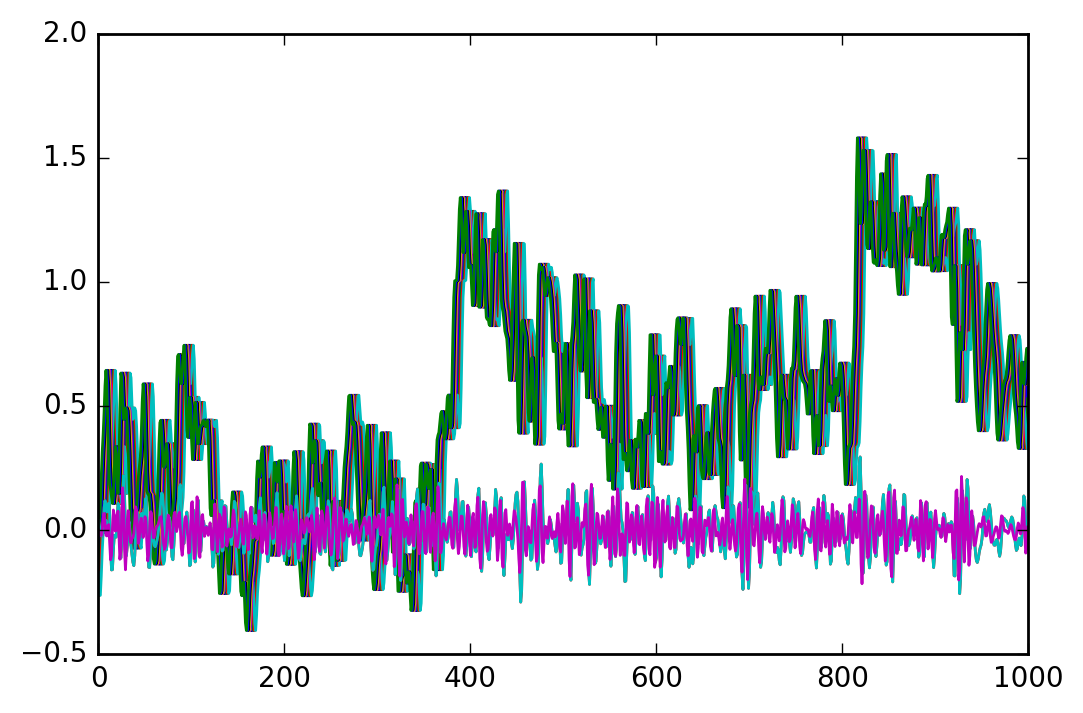

In [230]:
print calcium.shape
offset_mat = build_offset_features(calcium,5)
derivative_mat = build_derivative_features(calcium)
smooth_mat = build_smoothed_features(calcium,5)
print offset_mat.shape
print derivative_mat.shape
print smooth_mat.shape
print calcium_feature_mat.shape

calcium_feature_mat = np.vstack([calcium,smooth_mat,offset_mat,derivative_mat])

plt.plot(calcium_feature_mat[:,:1000].T);

In [219]:

toy_calcium = calcium_feature_mat[:,0:50000]
toy_spikes = spikes[0,0:50000]

X_train, X_test, y_train, y_test = train_test_split(toy_calcium.T, toy_spikes.T, test_size=0.2, random_state=0)
print X_train.shape

(40000, 19)


In [43]:
np.corrcoef(X_train[:,6],y_train)

array([[ 1.        ,  0.12448435],
       [ 0.12448435,  1.        ]])

In [221]:
params = {'objective': "binary:logistic",
'eval_metric': "error",
#'eta': 0.3, #step size shrinkage. larger--> more conservative / less overfitting
#'alpha':low_dim_l1_reg, #l1 regularization
#'lambda':low_dim_l2_reg, #l2 regularizaion
#'gamma':3, # default = 0, minimum loss reduction to further partitian on a leaf node. larger-->more conservative
#'max_depth': 5,
'seed': 16,
'silent': 1,
'missing': '-999.0',
#'colsample_bytree':.5 #new
}

dtrain = xgb.DMatrix(X_train, label=y_train)

dtest = xgb.DMatrix(X_test)
dtrain_y = xgb.DMatrix(X_train)

num_round = 200
model = xgb.train(params, dtrain, num_round)


Yr = model.predict(dtrain_y)
Yt = model.predict(dtest)

scores = model.get_score(importance_type='gain')


In [222]:
Yr_rounded = np.array([round(i) for i in Yr]);
Yt_rounded = np.array([round(i) for i in Yt]);
train_accuracy = accuracy_score(y_train,Yr_rounded)
print 'training accuracy: ' + str(train_accuracy)
test_accuracy = accuracy_score(y_test,Yt_rounded)
print 'testing accuracy: ' + str(test_accuracy)

train_precision = precision_score(y_train,Yr_rounded)
print 'training precision: ' + str(train_precision)
test_precision = precision_score(y_test,Yt_rounded)
print 'testing precision: ' + str(test_precision)

training accuracy: 0.99965
testing accuracy: 0.9862
training precision: 1.0
testing precision: 0.111111111111


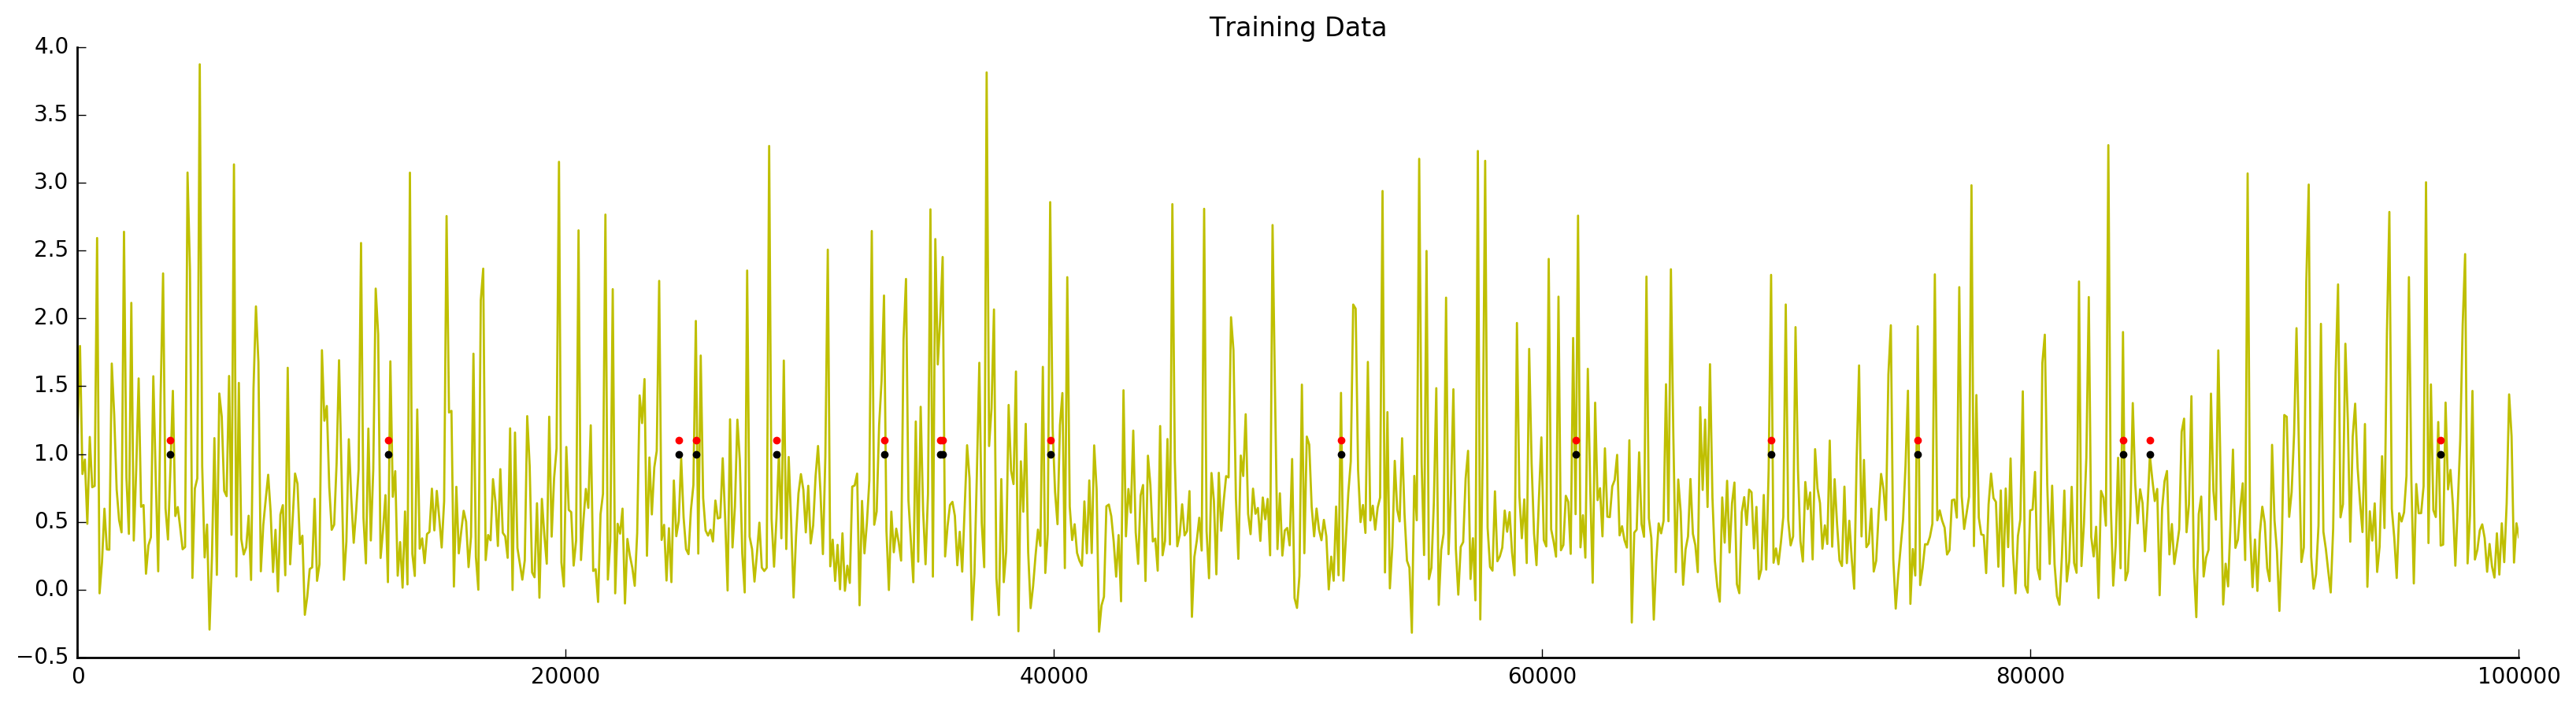

In [231]:
zoom_inds = [0,1000]
x_axis = np.linspace(zoom_inds[0],srate*zoom_inds[1],zoom_inds[1]-zoom_inds[0])

fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(x_axis,X_train[zoom_inds[0]:zoom_inds[1],0],'y')
ax1.set_title('Training Data')
plotting_Yr = Yr_rounded[zoom_inds[0]:zoom_inds[1]]
inds = np.where(plotting_Yr)
ax1.plot(x_axis[inds],plotting_Yr[inds],'k.')
plotting_y_train = y_train[zoom_inds[0]:zoom_inds[1]]
inds = np.where(plotting_y_train)
ax1.plot(x_axis[inds],plotting_y_train[inds]+0.1,'r.')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')

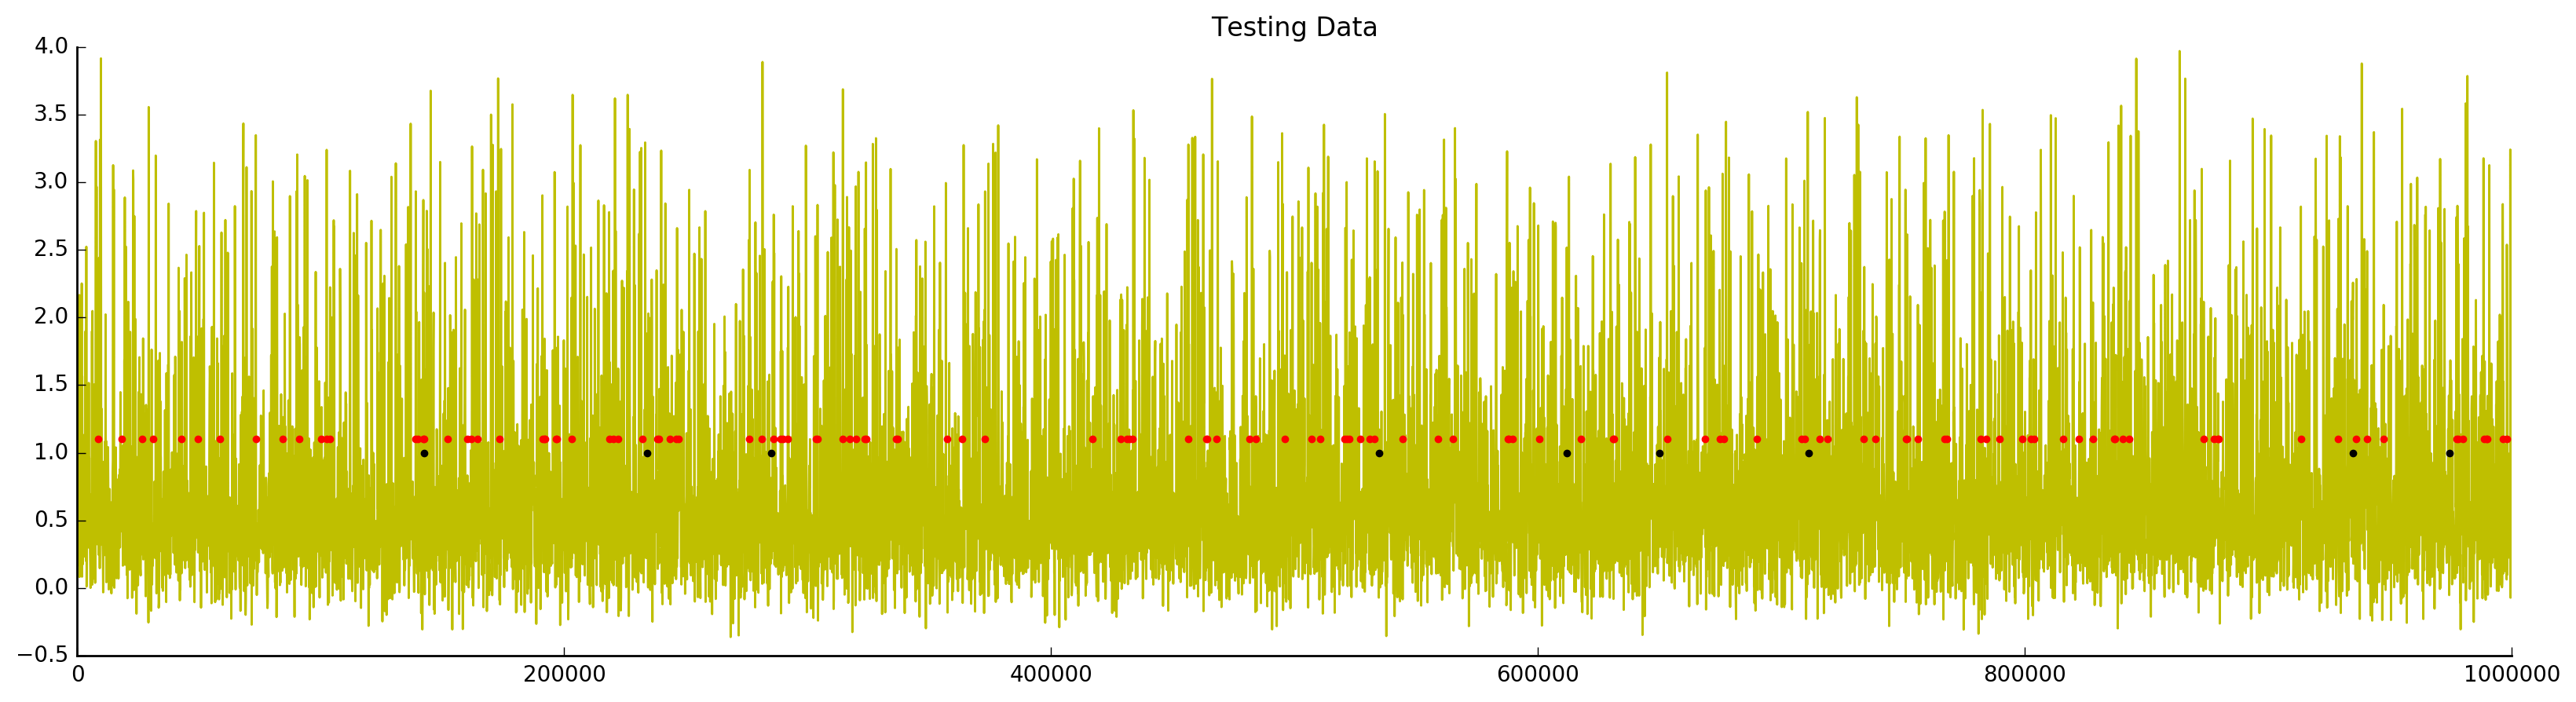

In [234]:
zoom_inds = [0,10000]
x_axis = np.linspace(zoom_inds[0],srate*zoom_inds[1],zoom_inds[1]-zoom_inds[0])

fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Testing Data')
ax1.plot(x_axis,X_test[zoom_inds[0]:zoom_inds[1],0],'y')
#ax1.plot(Yr,'b')
# nonzeros
plotting_Yt = Yt_rounded[zoom_inds[0]:zoom_inds[1]]
inds = np.where(plotting_Yt)
ax1.plot(x_axis[inds],plotting_Yt[inds],'k.')
plotting_y_test = y_test[zoom_inds[0]:zoom_inds[1]]
inds = np.where(plotting_y_test)
ax1.plot(x_axis[inds],plotting_y_test[inds]+0.1,'r.')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')

In [233]:

#sum(y_test==Yt_rounded)
# yuck
# from sklearn import svm
# clf = svm.SVC(probability=True)
# clf.fit(X_train, y_train.T)
# predictions = clf.predict(X_test)
actual_predictions = clf.predict(X_test)
plt.plot(y_test,predictions)
actual_predictions = clf.predict_proba(X_test)
#plt.plot(y_test,actual_predictions[:,1])
plt.plot(range(len(y_test)),y_test)
plt.plot(range(len(y_test)),actual_predictions[:,1])
np.corrcoef(actual_predictions[:,0],y_test)

AttributeError: 'function' object has no attribute 'predict'

In [ ]:
# also yuck
GLM = Sequential()
GLM.add(Dense(1, input_dim=X_train.shape[1], init='uniform', activation='linear'))
GLM.add(Dense(1,activation='softmax'))
GLM.compile(loss='binary_crossentropy', optimizer='adam')
GLM.fit(X_train, y_train,nb_epoch=3,batch_size=32);
#GLM.layers[0].get_weights()
Yr = GLM.predict(X_train)
Yt = GLM.predict(X_test)
train_accuracy = accuracy_score(y_train,Yr)
print 'training accuracy: ' + str(train_accuracy)
test_accuracy = accuracy_score(y_test,Yt)
print 'testing accuracy: ' + str(test_accuracy)

train_precision = precision_score(y_train,Yr)
print 'training precision: ' + str(train_precision)
test_precision = precision_score(y_test,Yt)
print 'testing precision: ' + str(test_precision)

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([0, 0, 1, 1])
sss = StratifiedShuffleSplit(n_splits=3, test_size=0.5, random_state=0)
for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]